In [5]:
# Import scaffoldgraph
import scaffoldgraph as sg

# Import networkx
import networkx as nx

# Import plotting tools
import matplotlib.pyplot as plt

# Import rdkit
from rdkit.Chem import Draw
from rdkit import Chem

import random
import os

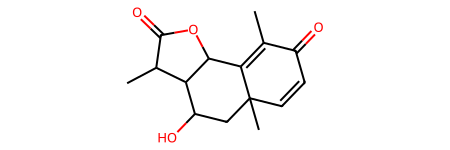

In [256]:
# Create a molecule from a SMILES string

# Artemisin
mol = Chem.MolFromSmiles('CC1C2C(CC3(C=CC(=O)C(=C3C2OC1=O)C)C)O')

# Tenofovir
# mol = Chem.MolFromSmiles('CC(CN1C=NC2=C(N=CN=C21)N)OCP(=O)(O)O')

# Ibuprofen
# mol = Chem.MolFromSmiles('CC(C)CC1=CC=C(C=C1)C(C)C(=O)O')

# Remdesivir
# mol = Chem.MolFromSmiles('CC1(OC2C(OC(C2O1)(C#N)C3=CC=C4N3N=CN=C4N)CO)C')

mol

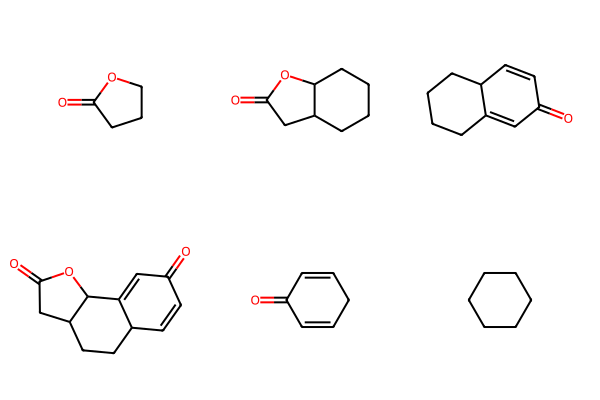

In [257]:
frags = sg.get_all_murcko_fragments(mol, break_fused_rings=True)
Draw.MolsToGridImage(frags)

In [258]:
[Chem.MolToSmiles(m) for m in frags]

['O=C1CCCO1',
 'O=C1CC2CCCCC2O1',
 'O=C1C=CC2CCCCC2=C1',
 'O=C1C=CC2CCC3CC(=O)OC3C2=C1',
 'O=C1C=CCC=C1',
 'C1CCCCC1']

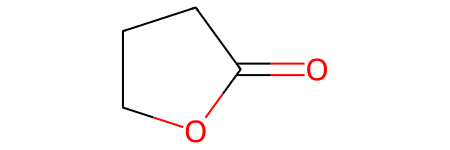

In [259]:
query_mol = Chem.MolFromSmiles("O=C1CCCO1")
query_mol

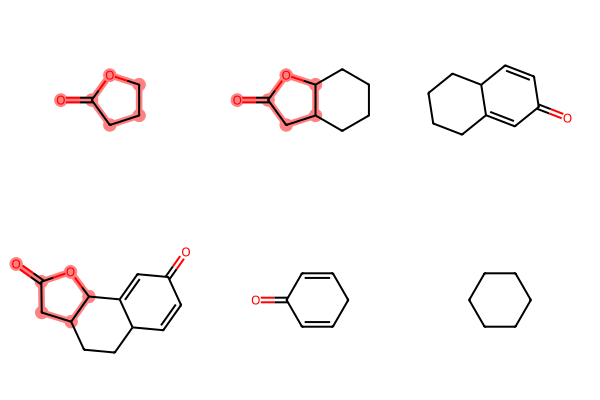

In [260]:
Draw.MolsToGridImage(frags, highlightAtomLists=[mol.GetSubstructMatch(query_mol) for mol in frags])

In [32]:
import pandas as pd

In [41]:
df = pd.DataFrame(data={"Smiles": ["CC1(OC2C(OC(C2O1)(C#N)C3=CC=C4N3N=CN=C4N)CO)C"], "Name": ["Remdesivir"]})
df

,Smiles,Name
0,CC1(OC2C(OC(C2O1)(C#N)C3=CC=C4N3N=CN=C4N)CO)C,Remdesivir


In [43]:
network = sg.ScaffoldNetwork.from_dataframe(df, progress=True)
n_scaffolds = network.num_scaffold_nodes
n_molecules = network.num_molecule_nodes

print('\nGenerated scaffold network from {} molecules with {} scaffolds\n'.format(n_molecules, n_scaffolds))

ScaffoldNetwork:   0%|                                                          | 0/1 [00:00<?, ?it/s]


Generated scaffold network from 1 molecules with 9 scaffolds



['c1ncc2ccc(C3OCC4OCOC43)n2n1', 'c1ncc2ccc(C3CCCO3)n2n1', 'c1cc2cncnn2c1', 'c1cc[nH]c1', 'c1c[nH]c(C2CCCO2)c1']


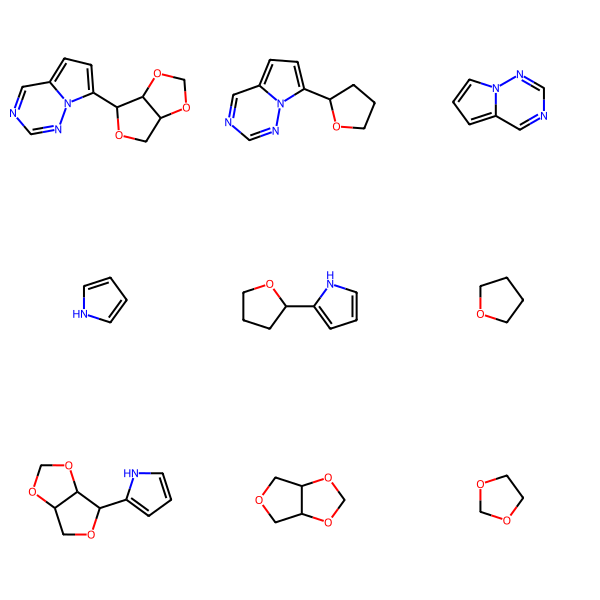

In [44]:
# We can obtain a list of SMILES strings representing scaffolds in the scaffold network

scaffolds = list(network.get_scaffold_nodes())
print(scaffolds[0:5])

# Visualize a few of the scaffolds

sample = 9
Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in scaffolds[:sample]])

In [49]:
molecules = list(network.get_molecule_nodes())
print(molecules[0:6], '\n')
pubchem_id = molecules[0]
pubchem_id

['Remdesivir'] 



'Remdesivir'

['Remdesivir', 'c1ncc2ccc(C3OCC4OCOC43)n2n1', 'c1ncc2ccc(C3CCCO3)n2n1', 'c1c[nH]c(C2OCC3OCOC32)c1', 'c1cc2cncnn2c1', 'c1c[nH]c(C2CCCO2)c1', 'C1OC2COCC2O1', 'c1cc[nH]c1', 'C1CCOC1', 'C1COCO1']


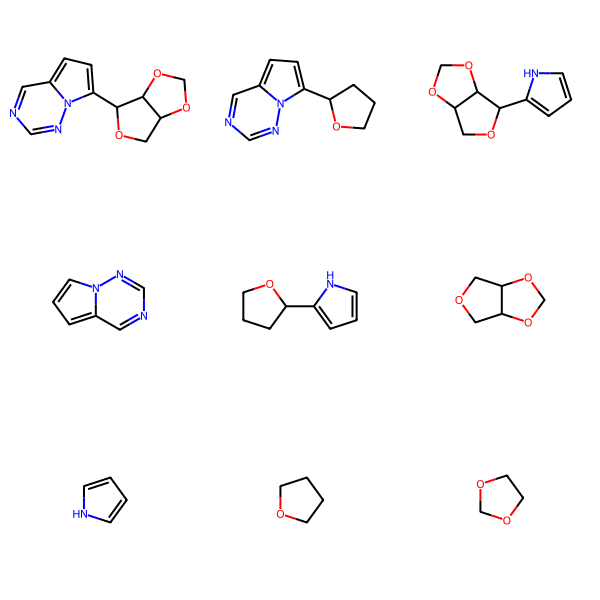

In [50]:
# Using the NetworkX API it is easy to find subscaffolds for a molcule of interest.
# We can use a breadth first search to find subscaffolds of the above molecule example.
# Scaffolds are predecessors of molecules as they form the molecules building blocks.

predecessors = list(nx.bfs_tree(network, pubchem_id, reverse=True))
print(predecessors)  # entry [0] is the search molecule 
Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in predecessors[1:]])

In [61]:
molecules = []
query_smiles = "c1ncc2ccc(C3OCC4OCOC43)n2n1"

for succ in nx.bfs_tree(network, query_smiles, reverse=False):
    print("Succ", succ, network.nodes[succ]['type'])
    if network.nodes[succ]['type'] == 'scaffold':
        molecules.append(succ)

Succ c1ncc2ccc(C3OCC4OCOC43)n2n1 scaffold
Succ Remdesivir molecule


In [62]:
molecules

['c1ncc2ccc(C3OCC4OCOC43)n2n1']

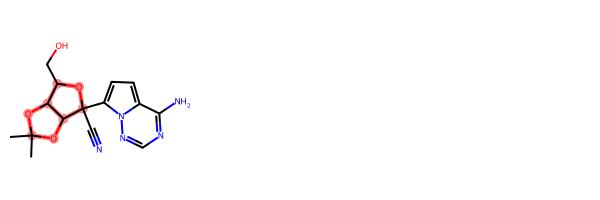

In [248]:
a = Chem.MolFromSmiles("CC1(OC2C(OC(C2O1)(C#N)C3=CC=C4N3N=CN=C4N)CO)C")
query = Chem.MolFromSmiles("C1OC2COCC2O1")
frags = [a]

Draw.MolsToGridImage(frags, highlightAtomLists=[mol.GetSubstructMatch(query) for mol in frags])

In [249]:
a.GetSubstructMatches(query)

((1, 2, 3, 4, 5, 6, 7, 8),)

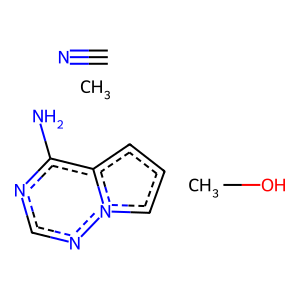

In [250]:
def atom_remover(mol,pattern):
    matches = mol.GetSubstructMatches(pattern)
    if not matches:
        yield Chem.Mol(mol)
    for match in matches:
        res = Chem.RWMol(mol)
        res.BeginBatchEdit()
        for aid in match:
            res.RemoveAtom(aid)
        res.CommitBatchEdit()

        display(Draw.MolToImage(res))
        # Chem.SanitizeMol(res)
        yield res

after = [x for x in atom_remover(a, query)]

In [251]:
s = Chem.MolToSmiles(after[0])

In [252]:
l = s.split(".")

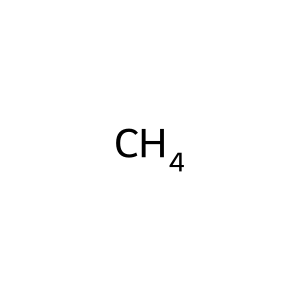

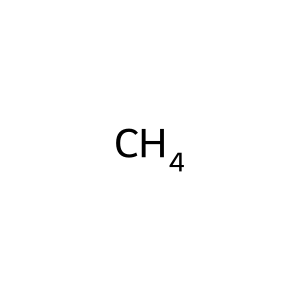

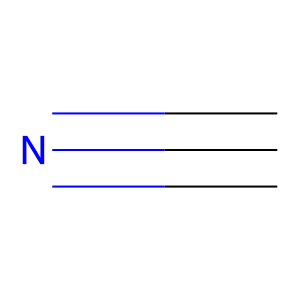

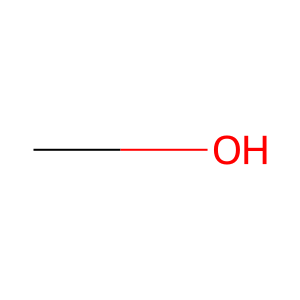

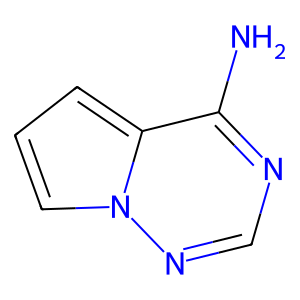

Complete


In [253]:
for a in l:
    try:
        t= Chem.MolFromSmiles(a)
        display(Draw.MolToImage(t))
    except Exception:
        b =  Chem.MolFromSmiles(a, sanitize=False)
        new_mol = Chem.RWMol(b)
        t = len(b.GetAtoms())
        new_mol.AddBond(0, t - 1, order=Chem.BondType.SINGLE)
        m = new_mol.GetMol()
        Chem.SanitizeMol(m)
        Chem.SetAromaticity(m)
        display(Draw.MolToImage(m))

print("Complete")

In [97]:
network

In [150]:
UnSanitized = Chem.MolFromSmiles("ncncN", sanitize=False)

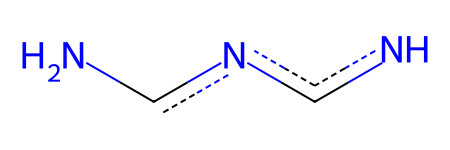

In [151]:
UnSanitized

In [156]:
for a in UnSanitized.GetAtoms():
    print(a.GetIsAromatic(), a.GetIdx(), a.GetSymbol())

True 0 N
True 1 C
True 2 N
True 3 C
False 4 N


In [220]:
b =  Chem.MolFromSmiles("ncncN", sanitize=False)

In [221]:
new_mol = Chem.RWMol(b)

In [222]:
new_mol.AddBond(0, 4, order=Chem.BondType.SINGLE)

5

In [254]:
m = new_mol.GetMol()
Chem.SanitizeMol(m)
Chem.SetAromaticity(m)

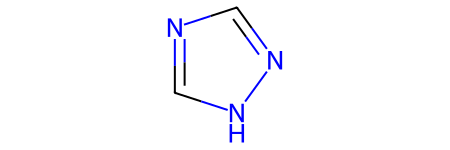

In [255]:
m

In [225]:
len(UnSanitized.GetAtoms())

5